300234	superai054	LT900011	LT900011-ai2310	EXP																					

In [1]:
!pwd

/home/superai052


In [2]:
!nvidia-smi

Thu Mar 16 00:56:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   32C    P0    51W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import time
import scipy

In [4]:
source_dataset_dir = Path(r"/lustrefs/disk/project/lt900038-ai23tn/frb_data/")
train_dir = source_dataset_dir / "train"
test_dir = source_dataset_dir / "test"
unlabeled_dir = source_dataset_dir / "unlabeled"
synthetic_dir = source_dataset_dir / "synthetic" 

In [5]:
# shape_count = Counter()

# for npy in tqdm(sorted(list(train_dir.glob("*.npy")))):
#     shape_count.update([np.load(npy).shape])

# shape_count

In [6]:
# shape_count = Counter()

# for csv in tqdm(sorted(list(train_dir.glob("*.csv")))):
#     df = pd.read_csv(csv)
#     display(df)
#     display(df.labels.value_counts())
#     shape_count.update([df.shape])
#     break

# shape_count

# Generate Train

In [16]:
test_df = []

for npy in tqdm(sorted(list(train_dir.glob("*.npy")))):
    csv = npy.with_name(f"{npy.stem}_labels.csv")
    df = pd.read_csv(csv)
    df = df["labels"]
    test_df.append(df)

print(len(test_df))
test_df = pd.concat(test_df, ignore_index=True)
print(len(test_df))
test_df.value_counts()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 731.59it/s]

97
94132


None             62988
Unlabeled         9554
Narrow            8582
Uncertain         5721
Pulse             3847
Broad             3196
Narrow+Broad       138
Narrow+Pulse        60
Unknown+Pulse       37
Broad+Pulse          9
Name: labels, dtype: int64

In [ ]:
def preprocess_signal(sub_signal):
    sub_signal = sub_signal - np.median(sub_signal, axis=0, keepdims=True)
    sub_signal = sub_signal / np.std(sub_signal, axis=0, keepdims=True)
    # sub_signal = (sub_signal - np.min(sub_signal)) / (np.max(sub_signal) - np.min(sub_signal))
    return sub_signal

def prepare_signal(npy_path: Path, 
                   filter_label: list[str], 
                   dataset_dir: Path) -> None:
    
    filename = npy_path.stem  # collect name

    # read csv
    csv_path = npy_path.with_name(f"{filename}_labels.csv")
    if not csv_path.exists():
        print(csv_path.name)
    label_df = pd.read_csv(csv_path)
    labels = label_df["labels"].str.lower().tolist()

    # load and split signal into 256 chunk
    signals = np.load(npy_path)
    signals = np.array(np.split(signals, len(labels)))

    # prepare data
    dataset_info = []
    for i, sub_signal in enumerate(signals):
        label = labels[i]

        if label in filter_label:
            continue
        
        actual_label = ["pulse" in label, 
                        "broad" in label, 
                        "narrow" in label]
        
        # preprocess signal and save it
        sub_signal = preprocess_signal(sub_signal=sub_signal).T
        image_path = dataset_dir / f"{filename}_{i}.png"
        plt.imsave(fname=os.fspath(image_path), arr=sub_signal)
        
        # append data
        dataset_info.append(
            [image_path,
             i,
             *actual_label]
            )
        
    # specify new df
    cols = ["path", "idx", "pulse", "broad", "narrow"]
    df = pd.DataFrame(dataset_info, columns=cols)
    
    # save csv
    df_dir = Path(r"csv")
    df_dir.mkdir(parents=True, exist_ok=True)
    df_path = df_dir / f"{filename}.csv"
    df.to_csv(df_path, index=False)

In [18]:
team_dir = Path(r"/home/superai052/super_workspace/weights/coatnet_2_rw_224/pod/asd")
team_dir.mkdir(parents=True, exist_ok=True)

In [21]:
team_dir = Path(r"/lustrefs/disk/project/lt900011-ai2310/")
dataset_dir = team_dir / "dataset"
dataset_name = "dataset_v1"
train_image_dir = dataset_dir/ dataset_name / "images"
train_image_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# list(train_dir.glob("*.npy"))

In [ ]:
from joblib import Parallel, delayed

filter_label = ["unlabeled", "uncertain"]
# train_data = []

_ = Parallel(n_jobs=4)(
    delayed(prepare_signal)(path, filter_label, train_image_dir) \
        for path in tqdm(sorted(list(train_dir.glob("*.npy"))))
)


In [ ]:
train_csv = list(Path(r"csv").iterdir())
train_csv[:2]

  0%|                                                                                                                                 | 0/97 [32:20<?, ?it/s]

In [ ]:
train_df = pd.concat([pd.read_csv(p) for p in train_csv], 
                     ignore_index=True)
train_df

In [ ]:
train_df.pulse.value_counts()

In [ ]:
train_df.board.value_counts()

In [ ]:
train_df.narrow.value_counts()

In [ ]:
train_df.columns = ["path", "idx", "pulse", "broad", "narrow"]

In [ ]:
train_df

In [ ]:
csv_path = dataset_dir / "data.csv"

train_df.to_csv(csv_path, index=False)

## Split Dataset

In [ ]:
df = train_df.copy()
df["label"] = df[["pulse", "broad", "narrow"]].apply(
    lambda row: f"{int(row.pulse)}{int(row.broad)}{int(row.narrow)}",
    axis=1
)
df

In [ ]:
df.label.value_counts()

In [ ]:
num_have_class = len(df[df.label != "000"])
num_none_class = len(df[df.label == "000"])
remove_none = df[df.label == "000"].sample(num_none_class-num_have_class).index.tolist()
df = df.drop(index=remove_none).reset_index(drop=True)
df

In [ ]:
from sklearn.model_selection import StratifiedKFold

X = df.path
y = df.label

kf = StratifiedKFold(n_splits=4)

# Iterate over the folds and train/validate the model
for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    # X_train, y_train = X[train_index], y[train_index]
    # X_val, y_val = X[val_index], y[val_index]
    
    train_df0 = df.loc[train_index]
    val_df = df.loc[val_index]
    break

In [ ]:
display(train_df0), display(val_df)

In [ ]:
val_df = val_df.reset_index(drop=True)

X = val_df.path
y = val_df.label

kf = StratifiedKFold(n_splits=2)

# Iterate over the folds and train/validate the model
for fold, (val_index, test_index) in enumerate(kf.split(X, y)):
    # X_train, y_train = X[train_index], y[train_index]
    # X_val, y_val = X[val_index], y[val_index]
    
    val_df0 = val_df.loc[val_index]
    test_df0 = val_df.loc[test_index]
    break

In [ ]:
display(val_df0), display(test_df0)

In [ ]:
train_csv = dataset_dir / "train.csv"
train_df0.to_csv(train_csv, index=False)

val_csv = dataset_dir / "val.csv"
val_df0.to_csv(val_csv, index=False)

test_csv = dataset_dir / "test.csv"
test_df0.to_csv(test_csv, index=False)

# Generate Synthetic

In [8]:
npy_paths = list(synthetic_dir.iterdir())
npy_paths

[PosixPath('/lustrefs/disk/project/lt900038-ai23tn/frb_data/synthetic/NBRFIs_50000_items_with_random_noise.npy'),
 PosixPath('/lustrefs/disk/project/lt900038-ai23tn/frb_data/synthetic/BBRFIs_50000_items_with_random_noise.npy'),
 PosixPath('/lustrefs/disk/project/lt900038-ai23tn/frb_data/synthetic/Pulses_DM_57_50000_items_with_random_noise.npy')]

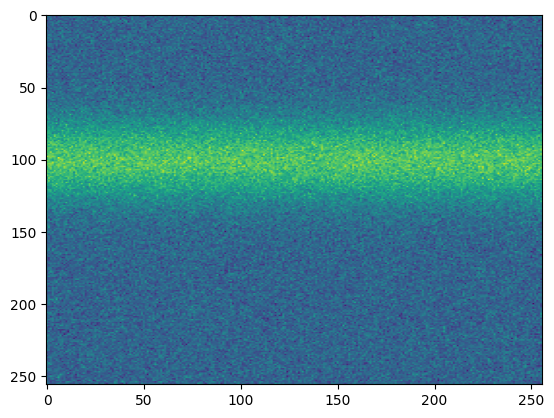

In [9]:
# freq x time shape
test_sig = np.load(npy_paths[0], mmap_mode="r")[0]
plt.imshow(test_sig, aspect="auto")
# plt.imshow(np.load(npy_paths[0], mmap_mode="r")[0], aspect="auto")

In [10]:
def prepare_signal(npy_path: Path, 
                   filter_label: list[str], 
                   dataset_dir: Path) -> None:
    
    filename = npy_path.stem  # collect name

    # read csv
    csv_path = npy_path.with_name(f"{filename}_labels.csv")
    if not csv_path.exists():
        print(csv_path.name)
    label_df = pd.read_csv(csv_path)
    labels = label_df["labels"].str.lower().tolist()

    # load and split signal into 256 chunk
    signals = np.load(npy_path)
    signals = np.array(np.split(signals, len(labels)))

    # prepare data
    dataset_info = []
    for i, sub_signal in enumerate(signals):
        label = labels[i]

        if label in filter_label:
            continue
        
        actual_label = ["pulse" in label, 
                        "broad" in label, 
                        "narrow" in label]
        
        # preprocess signal and save it
        sub_signal = preprocess_signal(sub_signal=sub_signal).T
        image_path = dataset_dir / f"{filename}_{i}.png"
        plt.imsave(fname=os.fspath(image_path), arr=sub_signal)
        
        # append data
        dataset_info.append(
            [image_path,
             i,
             *actual_label]
            )
        
    # specify new df
    cols = ["path", "idx", "pulse", "broad", "narrow"]
    df = pd.DataFrame(dataset_info, columns=cols)
    
    # save csv
    df_dir = Path(r"csv")
    df_dir.mkdir(parents=True, exist_ok=True)
    df_path = df_dir / f"{filename}.csv"
    df.to_csv(df_path, index=False)

In [11]:
def preprocess_signal(sub_signal):
    # sub_signal = sub_signal - np.mean(sub_signal, axis=0, keepdims=True)
    # sub_signal = sub_signal / np.std(sub_signal, axis=0, keepdims=True)
    sub_signal = (sub_signal - np.min(sub_signal)) / (np.max(sub_signal) - np.min(sub_signal))
    return sub_signal

def create_syn_dataset(path, dataset_dir):
    filename = path.stem
    label = filename.split("_")
    
    actual_label = ["Pulses" in label, 
                    "BBRFIs" in label, 
                    "NBRFIs" in label]
    
    # prepare data
    dataset_info = []
    i = 0  # , mmap_mode="r"
    for sub_signal in tqdm(np.load(path), desc=f"{filename}"):
        
        # preprocess signal and save it
        image_path = dataset_dir / f"{filename}_{i}.png"
        plt.imsave(fname=os.fspath(image_path), arr=sub_signal)

        # append data
        dataset_info.append(
            [image_path,
             i,
             *actual_label]
            )
        
        i += 1
        
    # specify new df
    cols = ["path", "idx", "pulse", "broad", "narrow"]
    df = pd.DataFrame(dataset_info, columns=cols)
    
    # save csv
    df_dir = Path(r"csv/syn")
    df_dir.mkdir(parents=True, exist_ok=True)
    df_path = df_dir / f"{filename}.csv"
    df.to_csv(df_path, index=False)

In [12]:
team_dir = Path(r"/lustrefs/disk/project/lt900011-ai2310/")
dataset_dir = team_dir / "dataset"
dataset_name = "dataset_v1"
syn_image_dir = dataset_dir/ dataset_name / "synthetic_images"
syn_image_dir.mkdir(parents=True, exist_ok=True)

In [13]:
npy_paths

[PosixPath('/lustrefs/disk/project/lt900038-ai23tn/frb_data/synthetic/NBRFIs_50000_items_with_random_noise.npy'),
 PosixPath('/lustrefs/disk/project/lt900038-ai23tn/frb_data/synthetic/BBRFIs_50000_items_with_random_noise.npy'),
 PosixPath('/lustrefs/disk/project/lt900038-ai23tn/frb_data/synthetic/Pulses_DM_57_50000_items_with_random_noise.npy')]

In [14]:
from joblib import Parallel, delayed

# filter_label = ["unlabeled", "uncertain"]
# train_data = []

# for path in npy_paths[]:
create_syn_dataset(npy_paths[-1], syn_image_dir)

# _ = Parallel(n_jobs=3)(
#     delayed(create_syn_dataset)(path, syn_image_dir) \
#         for path in npy_paths
# )


Pulses_DM_57_50000_items_with_random_noise: 100%|████████████████████████████████████████████████| 50000/50000 [24:42<00:00, 33.72it/s]
